<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/NN_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

ModuleNotFoundError: No module named 'tensorflow'

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [174]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [175]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])
    df['Time'] = d['time']
    df['Frame'] = range(0, 20)

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:20]

      #Assign labels to closest points
      df['Label'] = 0
      df.loc[closest_indices, 'Label'] = label
    else:
      df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
      # Append the current DataFrame to the main DataFrame
      df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()
display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

base_col = df_data.columns

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Frame,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10043.250,10.361,0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,9893.750,10.362,1,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,11016.000,10.363,2,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10170.375,10.364,3,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,8967.750,10.365,4,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,6837.500,8.622,15,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,4885.750,8.623,16,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,6152.000,8.624,17,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,2765.500,8.625,18,0,98005,905


Labels count:
0    12840
1     4140
2     1000
Name: Label, dtype: int64


In [176]:
#make a for loop per shot
shots = df_data['Shot'].unique()
#add a column to the dataframe called order
df_data['Order'] = 0
for shot in shots :
    #take frame 0
    df_shot = df_data[df_data['Shot'] == shot]
    df_shot = df_shot[df_shot['Frame'] == 0]
    #take the time of the frame 0
    time = df_shot['Time'].values

    for l in range (len(time)):
        #take the index in the data of the smallest time
        index = df_shot['Time'].idxmin()
        #set the order column of the index to 1
        df_data.loc[index, 'Order'] = l
        #set the order to the next 18 rows
        for i in range(1, 20):
            df_data.loc[index+i, 'Order'] = l
        #drop the value of the time array so the next smallest value will be taken
        df_shot = df_shot.drop(index)


def process_shot_group(group):
    minor_event_tracker = 0
    minor_events = []
    #sort by order column
    group = group.sort_values(by=['Order'])

    for i in group.index[::20]:  # Iterate over the index, stepping by 20
        minor_events.extend([minor_event_tracker] * 20)


        if group.at[i, 'Label'] == 1:  # Check the label at every 20th row
            minor_event_tracker += 1
        elif group.at[i, 'Label'] == 2:
            minor_event_tracker += 5

    group['Instability'] = minor_events
    return group

# Apply the function to each 'Shot' group
grouped_df = df_data.groupby('Shot').apply(process_shot_group).reset_index(drop=True)
# Display the result
grouped_df = grouped_df.groupby(by=['Shot', 'Order'], group_keys=False).apply(lambda x: x.sort_values(by=['Frame'])).reset_index(drop=True)

# Drop rows where 'ZMAG' has negative values
grouped_df = grouped_df[grouped_df['ZMAG'] >= 0]

columns_to_multiply = [col for col in grouped_df.columns if col != 'Label']
columns_to_multiply.remove('Vloop')
columns_to_multiply.remove('Shot')
columns_to_multiply.remove('Order')
# Now we will iterate over pairs of columns and create new columns for each pairing
for i, col1 in enumerate(columns_to_multiply):
    for col2 in columns_to_multiply[i+1:]:
        # Create a new column name based on the two column names
        new_col_name = f'log({col1}_x_{col2})'
        log_new_col_name = f'log({col1})_x_log({col2})'

        # PLaceholder
        df = pd.DataFrame()

        # Calculate the product of the two columns and assign to the new column
        df[new_col_name] = np.log(grouped_df[col1] * grouped_df[col2] + 1e-10)

        # Add to original DataFrame
        grouped_df = pd.concat([grouped_df, df], axis=1)

df_data = grouped_df.copy()

# Compute the correlation matrix
correlations = df_data.corr()

# Sort by the absolute values of the correlations with 'Label'
sorted_correlations = correlations['Label'].abs().sort_values(ascending=False)

print(sorted_correlations)
# Get the top 10 most correlated columns (excluding 'Label' itself)
top_10_correlated = sorted_correlations[1:3]

all_col = base_col.append(top_10_correlated.index)

df_data = df_data[all_col]
df_data = df_data.drop(columns='Frame')

Label                         1.000000
log(IPLA_x_Instability)       0.856693
log(SSXcore_x_Instability)    0.854304
log(ECEcore_x_Instability)    0.854024
log(Window_x_Instability)     0.853683
                                ...   
log(Time_x_Frame)             0.006803
log(IPLA_x_Frame)             0.006791
log(LI_x_Frame)               0.005769
log(Q95_x_Frame)              0.002373
Frame                         0.000396
Name: Label, Length: 82, dtype: float64


In [177]:
df_data.columns

Index(['IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop',
       'IPE', 'Time', 'Label', 'Shot', 'Window', 'log(IPLA_x_Instability)',
       'log(SSXcore_x_Instability)'],
      dtype='object')

We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [178]:
# Filter DataFrame to keep only rows where 'Label' matches the group's maximum 'Label'
df_data_filtered = df_data[df_data['Label'] == df_data.groupby(['Shot', 'Time'])['Label'].transform('max')]

print("Labels count after filtering:")
print(df_data_filtered['Label'].value_counts())

# Split 'Shot' values into training and test sets and create DataFrames
shot_train, shot_test = train_test_split(df_data_filtered['Shot'].unique(), test_size=0.2, random_state=42)
train_df = df_data_filtered[df_data_filtered['Shot'].isin(shot_train)]
test_df = df_data_filtered[df_data_filtered['Shot'].isin(shot_test)]

# Separate features and label, and drop some columns
X_train, y_train = train_df.drop(columns=['Window', 'Shot', 'Label']), train_df['Label']
X_test, y_test = test_df.drop(columns=['Window', 'Shot', 'Label']), test_df['Label']

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform here, not fit_transform

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Labels count after filtering:
0    12802
1     3848
2     1000
Name: Label, dtype: int64


#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [162]:
def build_model(hp):
    model = keras.Sequential()

    # Hyperparameters for regularization
    reg_l1 = hp.Choice('l1_reg', values=[1e-4, 1e-3, 1e-2])
    reg_l2 = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])

    # Hyperparameter for the number of dense layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Let's say we want between 1 and 3 dense layers
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                     activation='relu'
                                     ,kernel_regularizer=regularizers.L1L2(l1=reg_l1, l2=reg_l2)
                                     ))

    model.add(keras.layers.Dense(3, activation='softmax'))  # Output layer

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model with F1 score for each category as a metric
    model.compile(loss='kl_divergence',
                  optimizer=keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy',tfa.metrics.F1Score(num_classes=3, average=None)])

    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # number of model configurations to try
    executions_per_trial=1,  # number of models that should be built and fit for each trial
    directory='my_dir7',
    project_name='helloworld')

tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 10s]
val_loss: 0.4101237952709198

Best val_loss So Far: 0.2365683764219284
Total elapsed time: 00h 01m 44s


In [163]:
# Get the best models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=X_train.shape)

# Architecture of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (14138, 448)              68096     
                                                                 
 dense_1 (Dense)             (14138, 32)               14368     
                                                                 
 dense_2 (Dense)             (14138, 3)                99        
                                                                 
Total params: 82563 (322.51 KB)
Trainable params: 82563 (322.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate the model on the test set
scores = best_model.evaluate(X_test, y_test)
f1_scores = scores[2:]
print(f"F1 Scores for test set: {f1_scores}")

#**III - Evaluation of the best model**

We evaluate the best model's performances on an isolated shot.

In [179]:
# Load best Neural Network
nn_model = tf.keras.models.load_model("/content/drive/MyDrive/best.keras")

# Evaluate the model on the test set
nn_scores = nn_model.evaluate(X_test, y_test)
f1_scores = nn_scores[2:]
print(f"F1 Scores for test set: {f1_scores}")

99/99 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9749 - f1_score: 0.9242
F1 Scores for test set: [array([0.9923902 , 0.9084589 , 0.87179494], dtype=float32)]


In [181]:
labels = to_categorical(df_data_filtered['Label'])
labels_df = pd.DataFrame(labels)
df_cat = df_data_filtered.reset_index(drop=True).join(labels_df)

# Get values of a single shot
shot = 95467
df_shot = df_cat[df_cat['Shot'] == shot].drop(columns=['Window', 'Shot', 'Label'])
df_shot = df_shot.drop(columns=labels_df.columns)

# Label of the shot
label_shot = df_cat[df_cat['Shot'] == shot][labels_df.columns].values

# Normalize the shot
scaler = StandardScaler()
df_shot = scaler.fit_transform(df_shot)

# Predict the probabilities for each label
prediction_probabilities = nn_model.predict(df_shot)

10/10 [==============================] - 0s 2ms/step


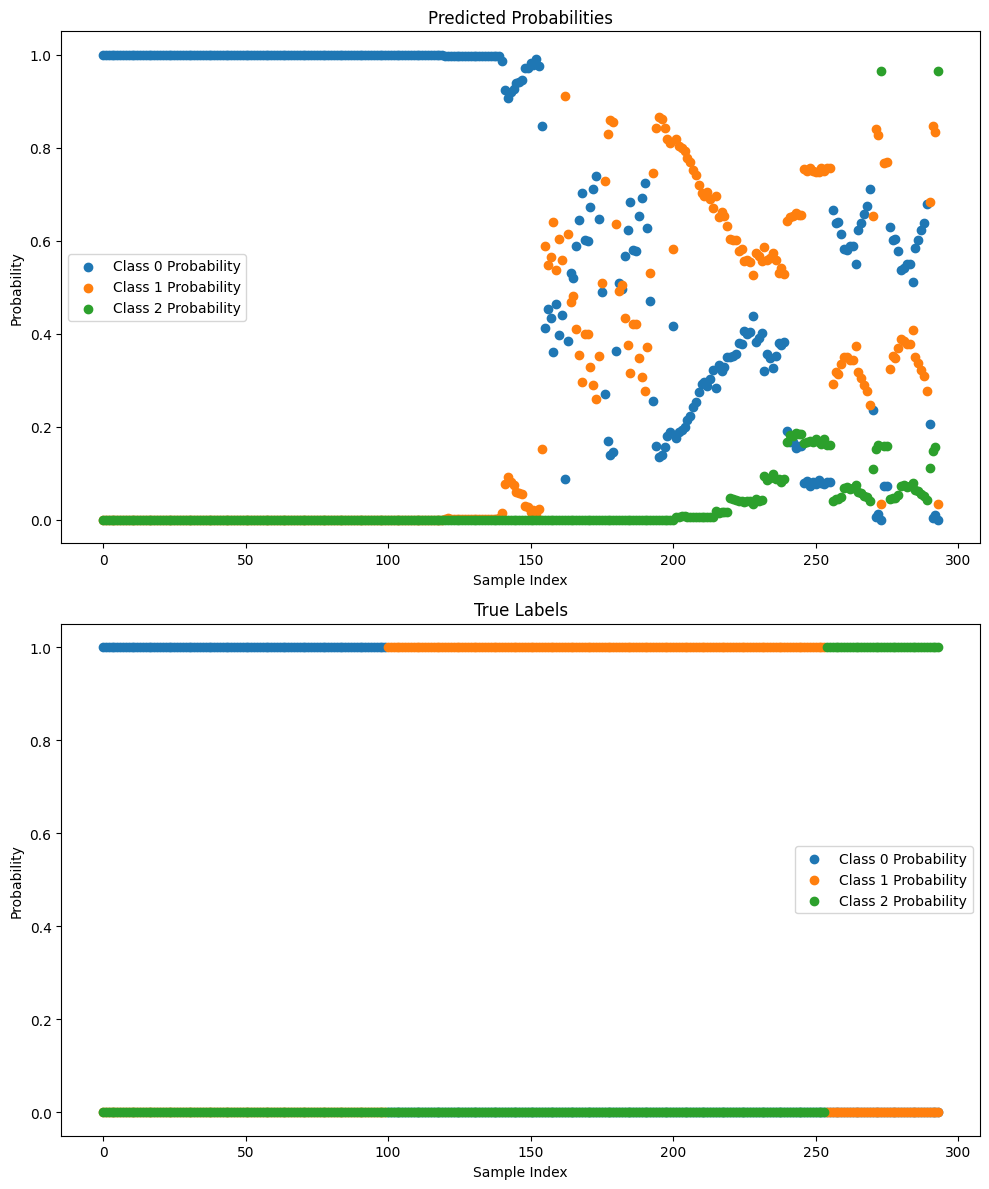

In [182]:
num_samples = df_shot.shape[0]
num_classes = prediction_probabilities.shape[1]

# Create a figure with 2 subplots arranged vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot predicted probabilities on the first subplot
for i in range(num_classes):
    axs[0].scatter(np.arange(num_samples), prediction_probabilities[:, i], label=f'Class {i} Probability')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Probability')
axs[0].set_title('Predicted Probabilities')
axs[0].legend()

# Plot true labels on the second subplot
for i in range(num_classes):
    axs[1].scatter(np.arange(num_samples), label_shot[:, i], label=f'Class {i} Probability')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Probability')
axs[1].set_title('True Labels')
axs[1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()
